# Zillow Price (Zestimate)

Project Link: https://www.kaggle.com/competitions/zillow-prize-1

In this million-dollar competition, participants will develop an algorithm that makes predictions about the future sale prices of homes. The contest is structured into two rounds, the qualifying round which opens May 24, 2017 and the private round for the 100 top qualifying teams that opens on Feb 1st, 2018. In the qualifying round, you’ll be building a model to improve the Zestimate residual error. In the final round, you’ll build a home valuation algorithm from the ground up, using external data sources to help engineer new features that give your model an edge over the competition.

This challenge is a Regression problem that evaluates the Mean Absolute Error between the Predicted and Actual log error of house prices in Zillow using the formula: logerror = log(Zestimate) - log(SalesPrice)

Four datasets exist (two of them being training sets based on 2016 and 2017 house prices and two of them being actual property prices in 2016 and 2017). Datasets were merged based on 2016 and 2017, and then combined into a final 'full_df' dataset that can be compared overall.

# Import Statements & Importing Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

%matplotlib inline

In [2]:
train = pd.read_csv('/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/train_2016_v2.csv', 
                    parse_dates=["transactiondate"])
props = pd.read_csv('/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/props_2016.csv')
sample = pd.read_csv('/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/sample_submission.csv')

In [3]:
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


# Data Understanding

In [4]:
props.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015,239695.0,5725.17,NaN,NaN,NaN


In [5]:
# Check data types
data_types = props.dtypes

# Print data types along with additional information
print("Data Types and Additional Information:")
for column in props.columns:
    print(f"Column: {column}")
    print(f" - Data Type: {data_types[column]}")
    print(f" - Number of Unique Values: {props[column].nunique()}")
    print(f" - Sample Values: {props[column].dropna().unique()[:5]}")  # Display first 5 unique non-null values
    print()

Data Types and Additional Information:
Column: parcelid
 - Data Type: int64
 - Number of Unique Values: 9999
 - Sample Values: [10754147 10759547 10843547 10859147 10879947]

Column: airconditioningtypeid
 - Data Type: float64
 - Number of Unique Values: 2
 - Sample Values: [ 1. 13.]

Column: architecturalstyletypeid
 - Data Type: float64
 - Number of Unique Values: 0
 - Sample Values: []

Column: basementsqft
 - Data Type: float64
 - Number of Unique Values: 8
 - Sample Values: [216. 555. 224. 782. 651.]

Column: bathroomcnt
 - Data Type: float64
 - Number of Unique Values: 19
 - Sample Values: [0. 2. 4. 3. 1.]

Column: bedroomcnt
 - Data Type: float64
 - Number of Unique Values: 13
 - Sample Values: [0. 4. 5. 2. 3.]

Column: buildingclasstypeid
 - Data Type: float64
 - Number of Unique Values: 4
 - Sample Values: [3. 4. 5. 2.]

Column: buildingqualitytypeid
 - Data Type: float64
 - Number of Unique Values: 6
 - Sample Values: [ 7.  4. 10.  1. 12.]

Column: calculatedbathnbr
 - Data T

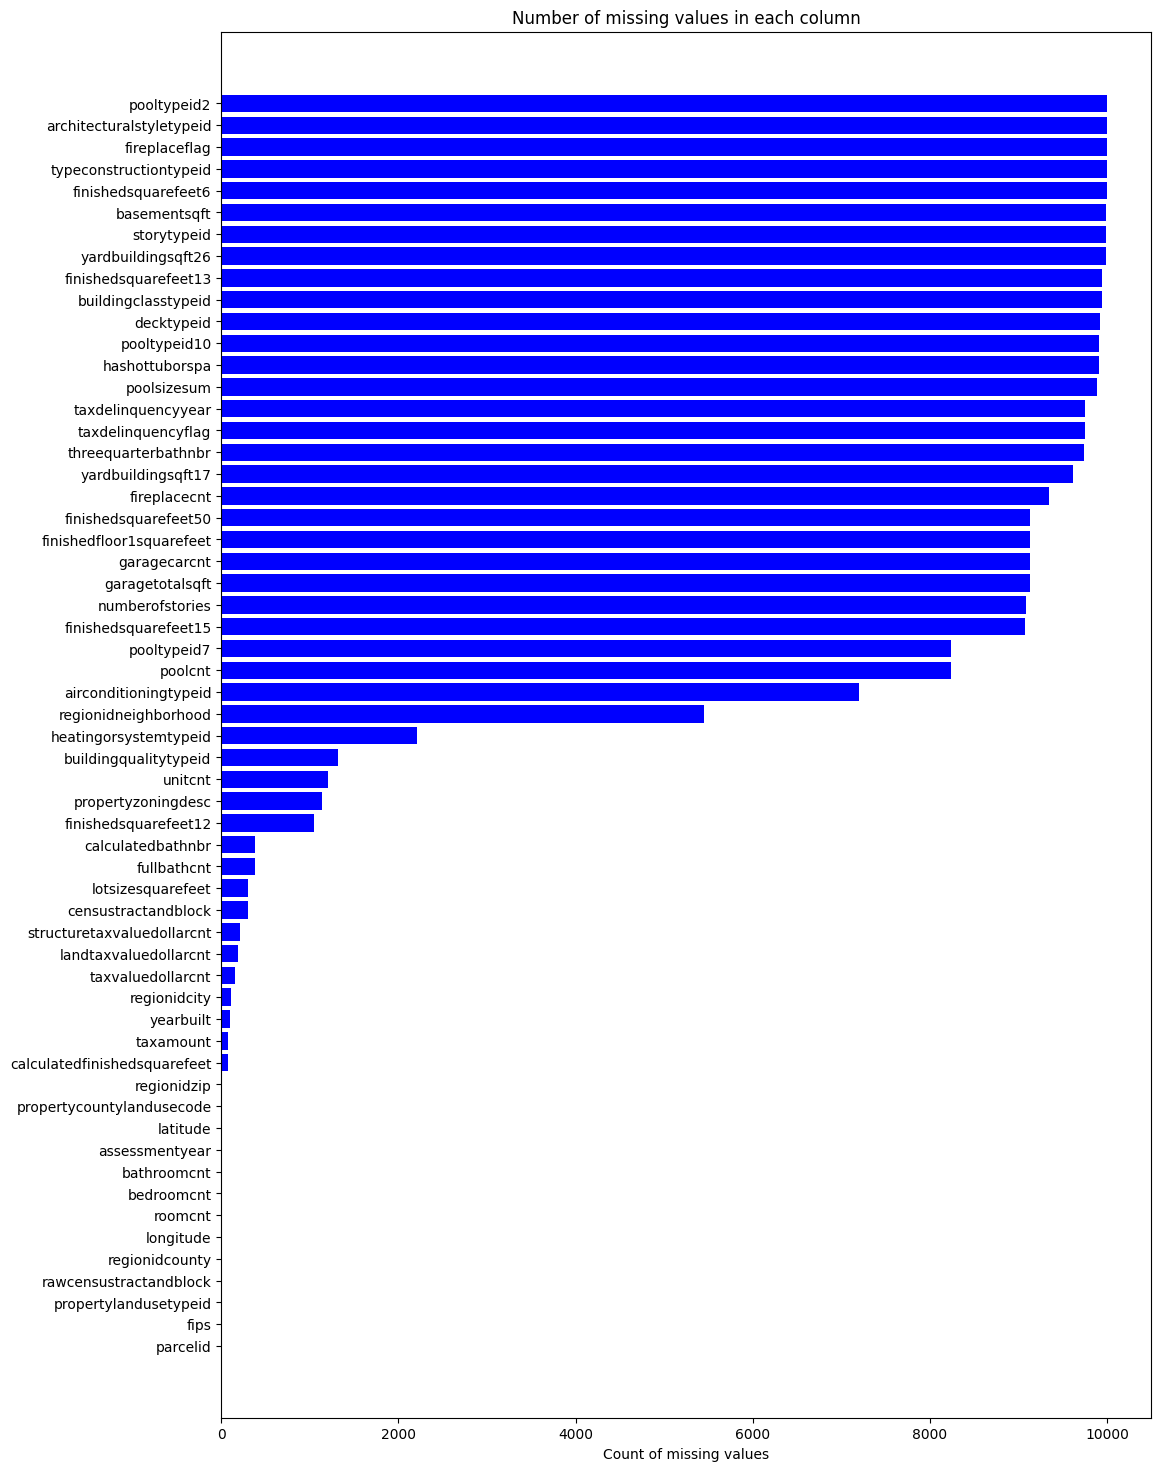

In [6]:
missing = props.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
#missing = missing.ax[missing_df['missing_count']>0]
missing = missing.sort_values(by='missing_count')

ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [7]:
# Merging Datasets
final = props.copy()
final= final.merge(train,on='parcelid',how='left')
print('Shape of Dataframe: ',final.shape)
final.head()

Shape of Dataframe:  (9999, 60)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,9.0,2015,9.0,NaN,NaN,NaN,NaN,NaN,NaT
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,27516.0,2015,27516.0,NaN,NaN,NaN,NaN,NaN,NaT
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,650756.0,1413387.0,2015,762631.0,20800.37,NaN,NaN,NaN,NaN,NaT
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,571346.0,1156834.0,2015,585488.0,14557.57,NaN,NaN,NaN,NaN,NaT
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,193796.0,433491.0,2015,239695.0,5725.17,NaN,NaN,NaN,NaN,NaT


## EDA Time

In [8]:
zillow=final.copy()

In [9]:
dtypes = zillow.dtypes.reset_index()
dtypes.columns=['Count','Column Type']
dtypes

,Count,Column Type
0,parcelid,int64
1,airconditioningtypeid,float64
2,architecturalstyletypeid,float64
3,basementsqft,float64
4,bathroomcnt,float64
5,bedroomcnt,float64
6,buildingclasstypeid,float64
7,buildingqualitytypeid,float64
8,calculatedbathnbr,float64
9,decktypeid,float64


In [10]:
zillow.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror,transactiondate
count,9.999000e+03,2802.000000,0.0,8.000000,9999.000000,9999.000000,61.000000,8685.000000,9616.000000,74.0,...,0.0,9.790000e+03,9.842000e+03,9999.000000,9.812000e+03,9925.000000,244.000000,9.702000e+03,264.000000,264
mean,1.252630e+07,1.017131,NaN,534.500000,2.138014,3.067707,3.770492,5.916062,2.223170,66.0,...,NaN,1.601743e+05,3.909692e+05,2014.999300,2.323494e+05,5052.175427,13.844262,6.044639e+13,0.028170,2016-06-12 18:27:16.363636480
min,1.071722e+07,1.000000,NaN,216.000000,0.000000,0.000000,2.000000,1.000000,1.000000,66.0,...,NaN,5.000000e+00,9.000000e+00,2014.000000,4.000000e+00,19.070000,7.000000,6.037101e+13,-1.435000,2016-01-05 00:00:00
25%,1.145614e+07,1.000000,NaN,443.000000,1.000000,2.000000,4.000000,4.000000,2.000000,66.0,...,NaN,7.134175e+04,1.599235e+05,2015.000000,6.261800e+04,2255.130000,14.000000,6.037263e+13,-0.024550,2016-04-12 18:00:00
50%,1.211635e+07,1.000000,NaN,577.500000,2.000000,3.000000,4.000000,7.000000,2.000000,66.0,...,NaN,1.160270e+05,2.783050e+05,2015.000000,1.481010e+05,3699.990000,14.000000,6.037482e+13,0.009000,2016-06-06 12:00:00
75%,1.271249e+07,1.000000,NaN,671.250000,3.000000,4.000000,4.000000,7.000000,3.000000,66.0,...,NaN,1.840435e+05,4.428485e+05,2015.000000,2.759475e+05,5725.120000,15.000000,6.037621e+13,0.055650,2016-08-16 12:00:00
max,1.631873e+08,13.000000,NaN,782.000000,12.000000,12.000000,5.000000,12.000000,12.000000,66.0,...,NaN,1.311502e+07,2.971371e+07,2015.000000,2.210127e+07,362406.910000,15.000000,6.111009e+13,2.758000,2016-12-30 00:00:00
std,3.205463e+06,0.453153,NaN,212.717116,1.124080,1.314482,0.496435,1.728584,1.060449,0.0,...,NaN,2.770741e+05,6.762267e+05,0.026451,4.514329e+05,8311.246009,1.653133,2.186742e+11,0.235136,NaN


In [11]:
missing = [var for var in zillow.columns if zillow[var].isnull().sum()>0]

zillow[missing].isnull().sum()

airconditioningtypeid           7197
architecturalstyletypeid        9999
basementsqft                    9991
buildingclasstypeid             9938
buildingqualitytypeid           1314
calculatedbathnbr                383
decktypeid                      9925
finishedfloor1squarefeet        9130
calculatedfinishedsquarefeet      74
finishedsquarefeet12            1048
finishedsquarefeet13            9947
finishedsquarefeet15            9078
finishedsquarefeet50            9130
finishedsquarefeet6             9998
fireplacecnt                    9348
fullbathcnt                      383
garagecarcnt                    9127
garagetotalsqft                 9127
hashottuborspa                  9912
heatingorsystemtypeid           2209
lotsizesquarefeet                299
poolcnt                         8238
poolsizesum                     9883
pooltypeid10                    9912
pooltypeid2                     9999
pooltypeid7                     8238
propertycountylandusecode          3
p

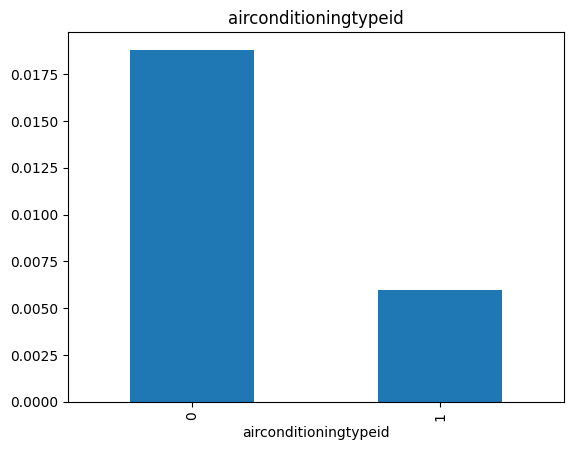

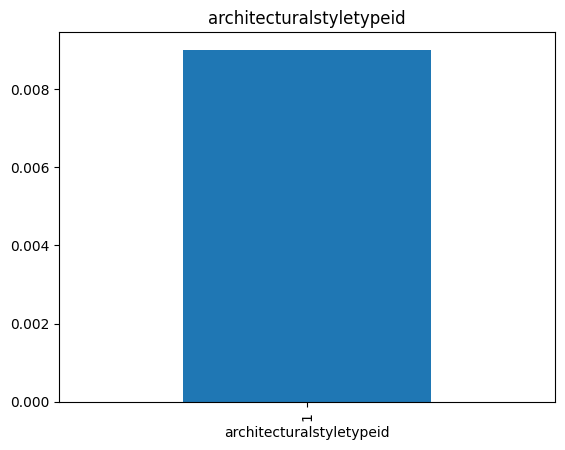

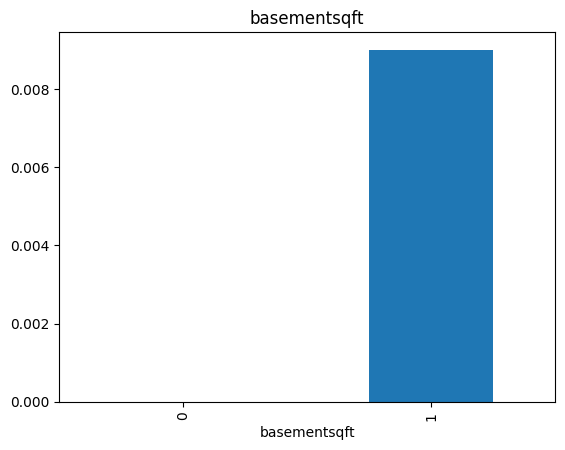

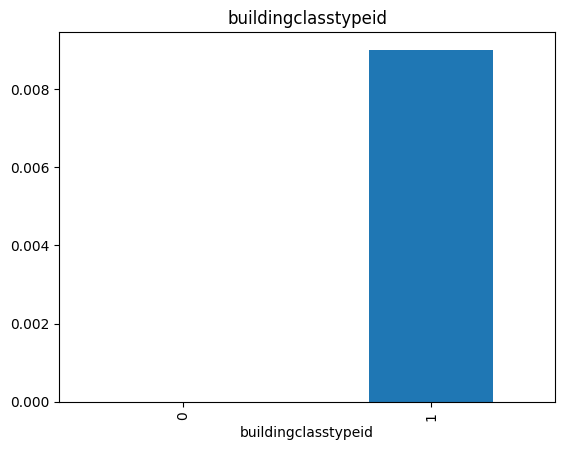

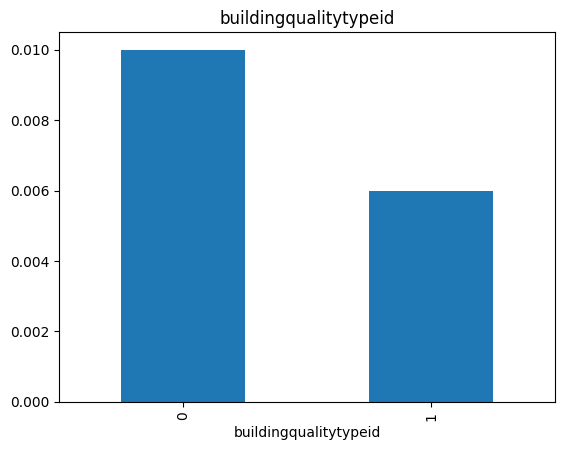

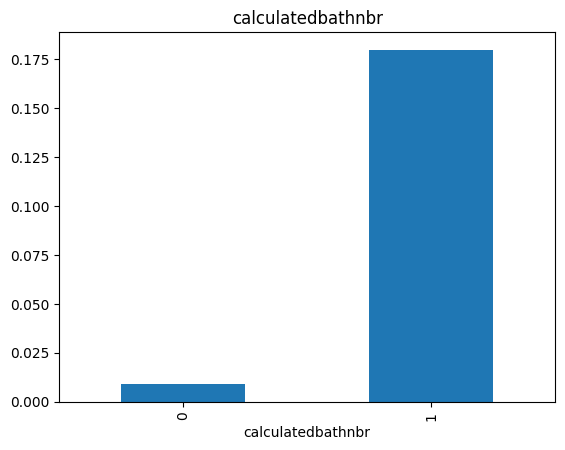

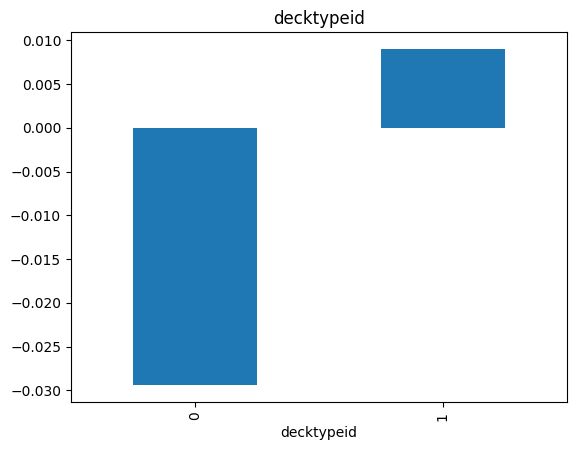

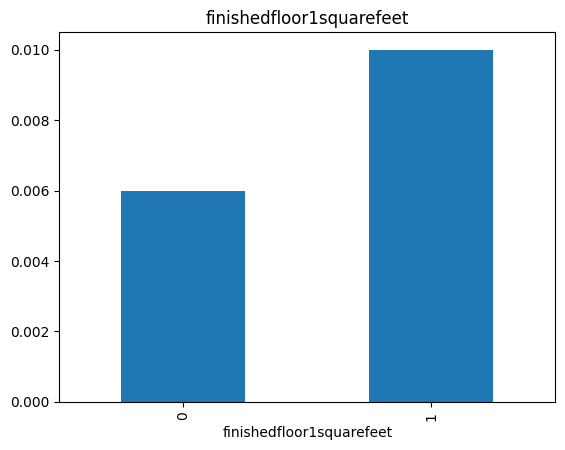

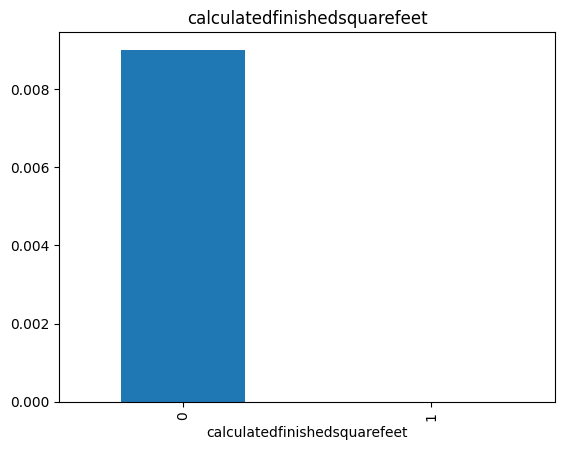

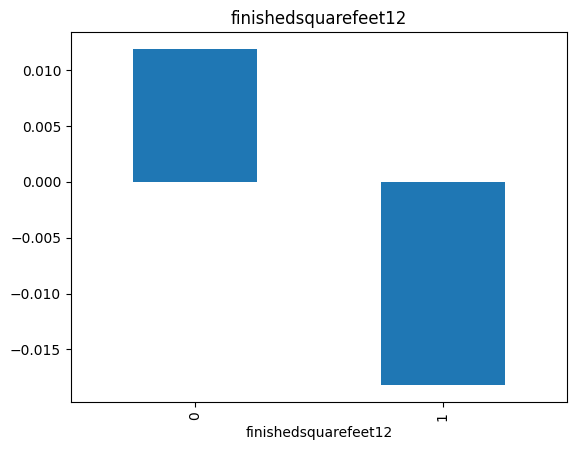

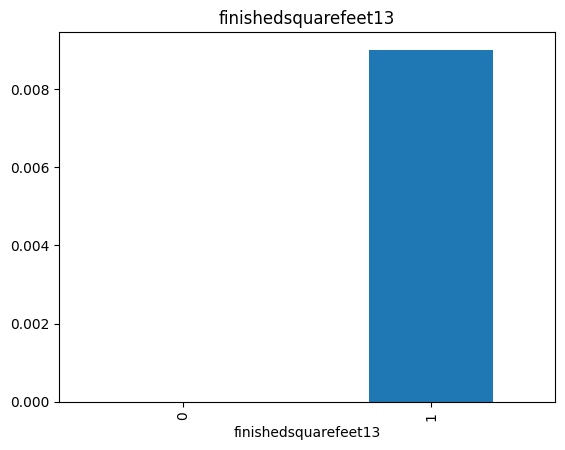

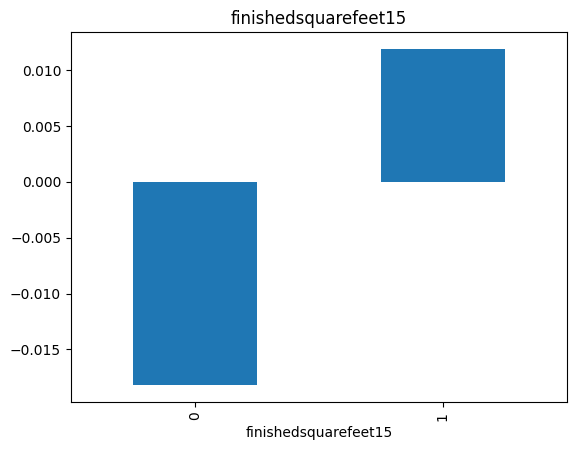

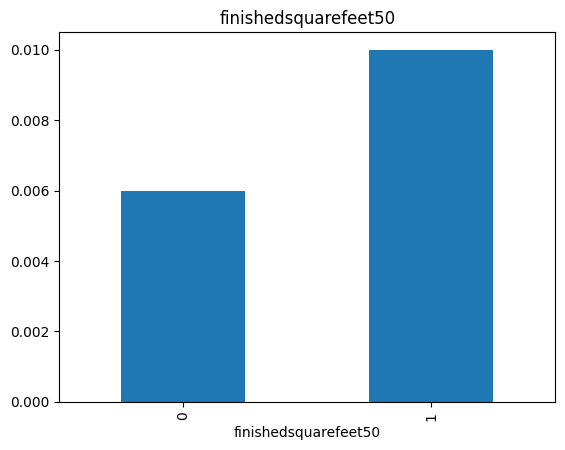

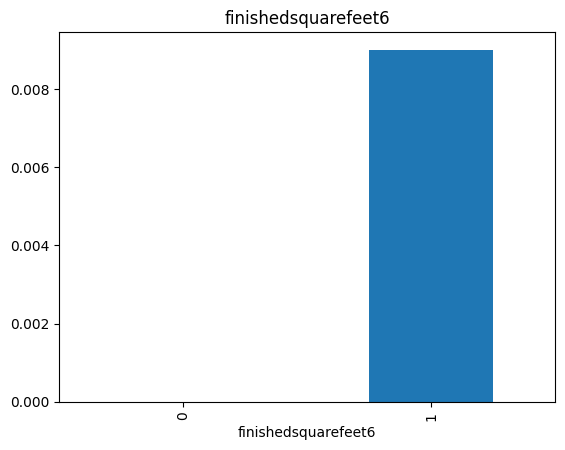

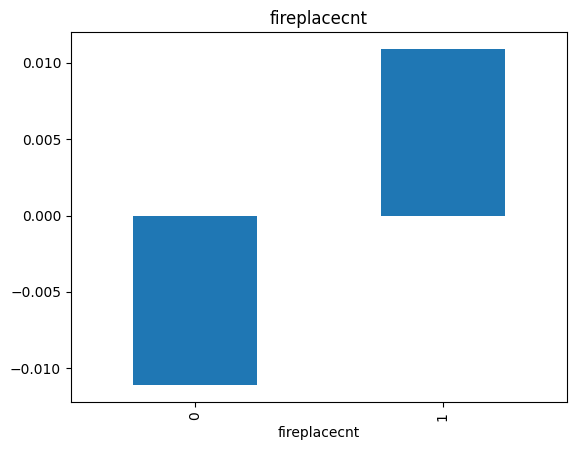

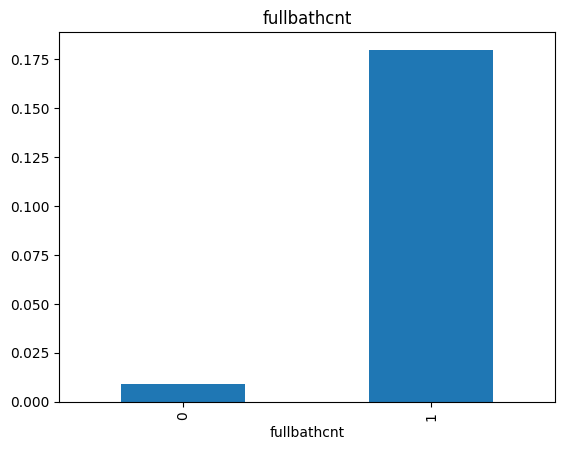

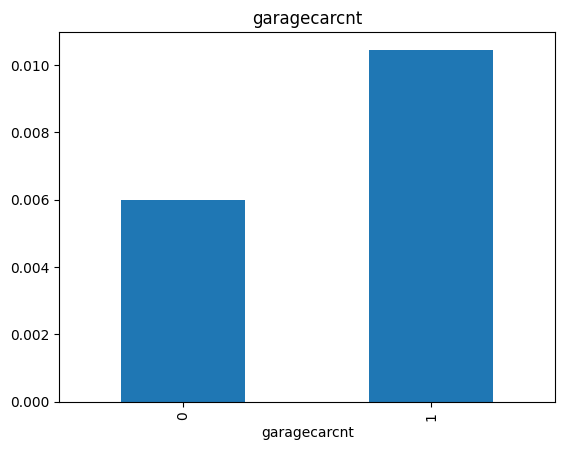

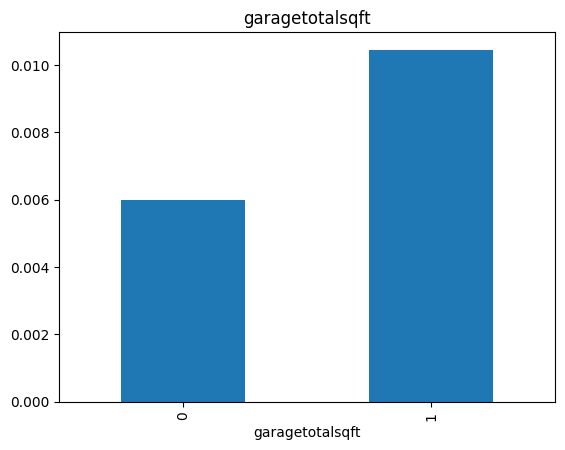

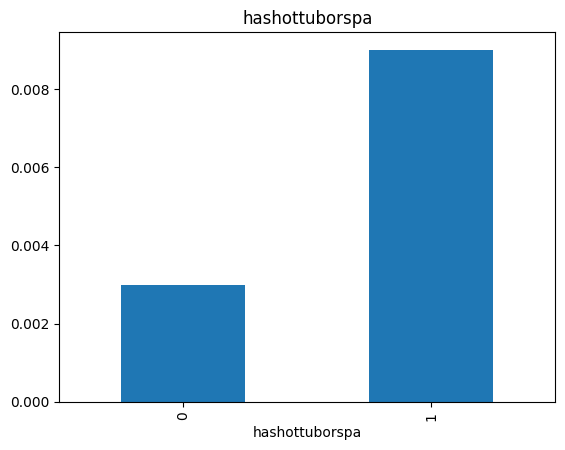

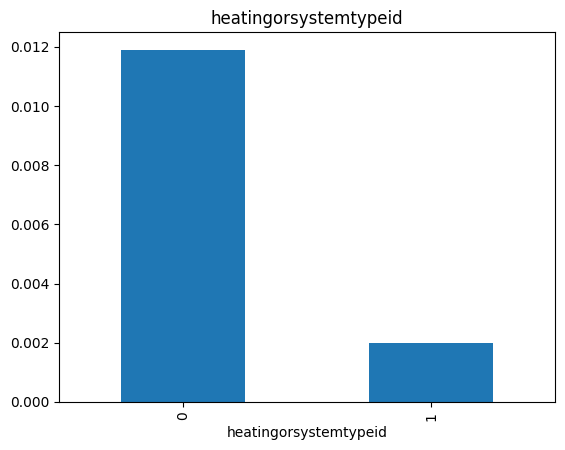

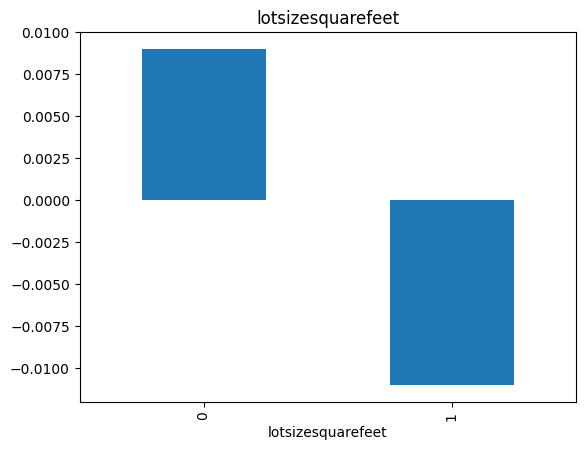

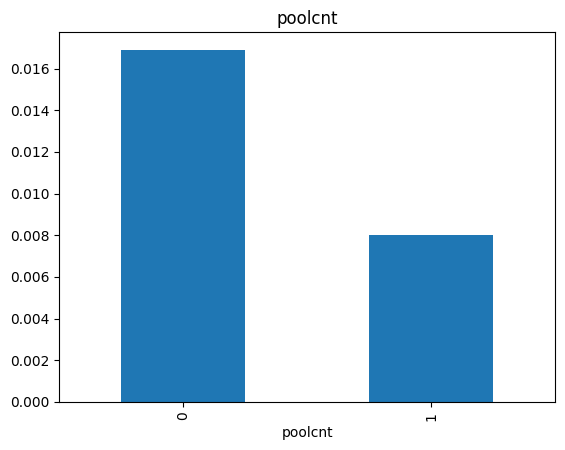

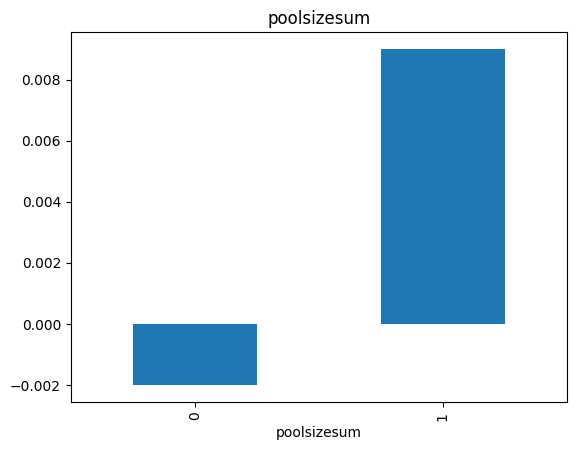

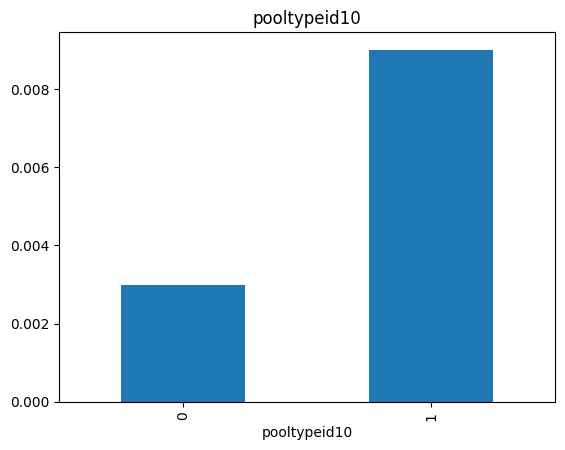

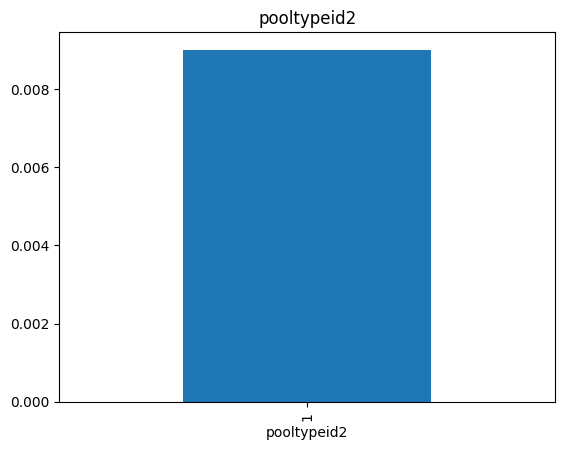

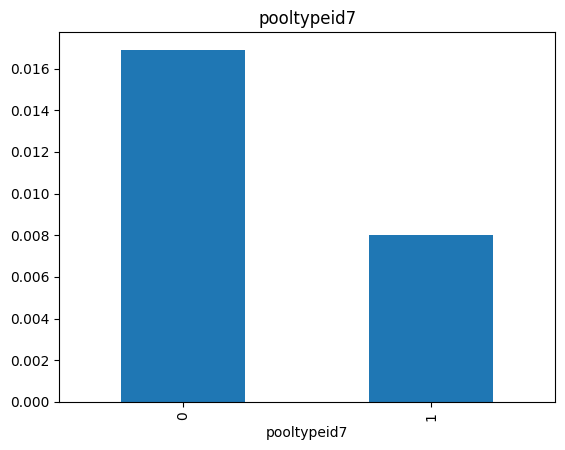

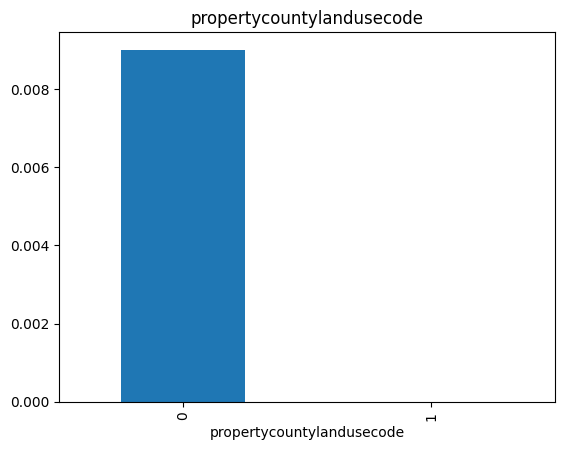

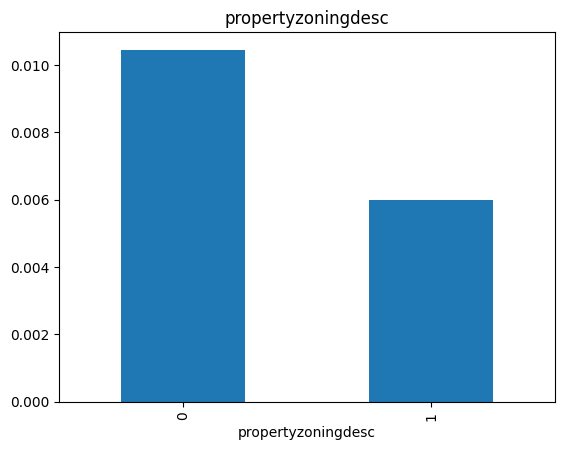

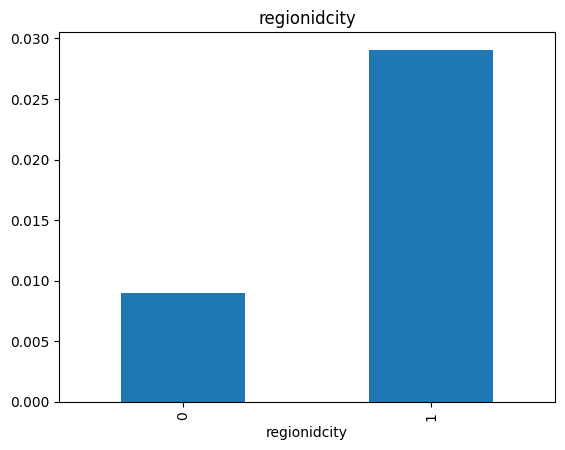

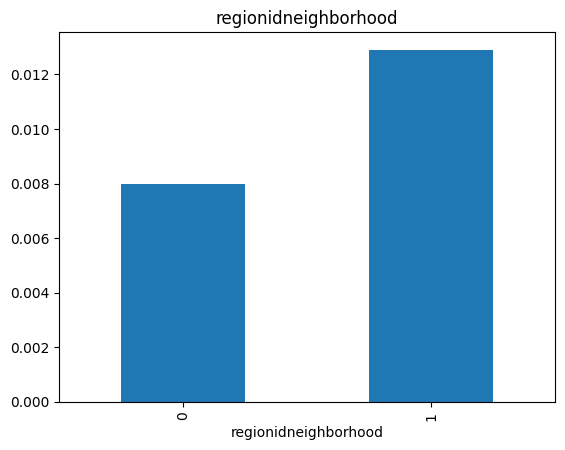

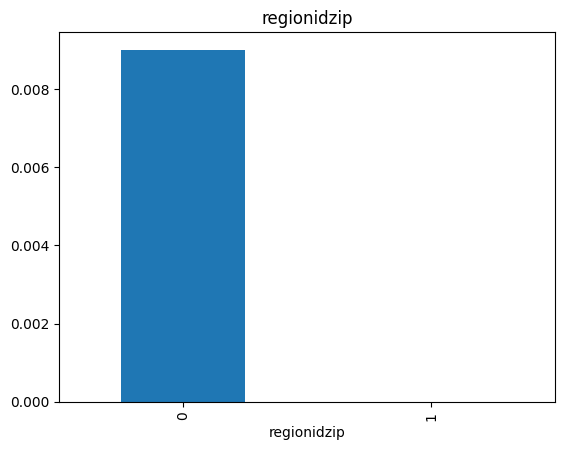

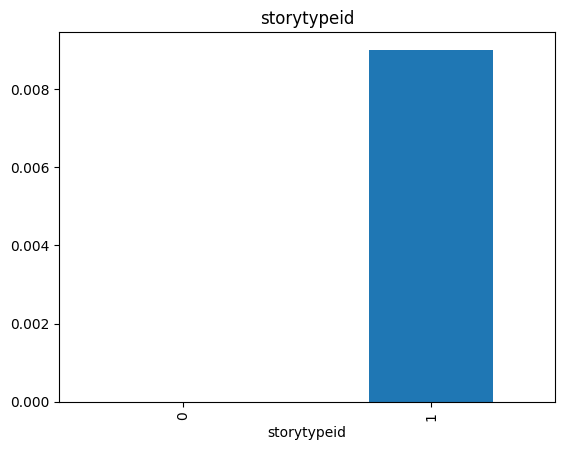

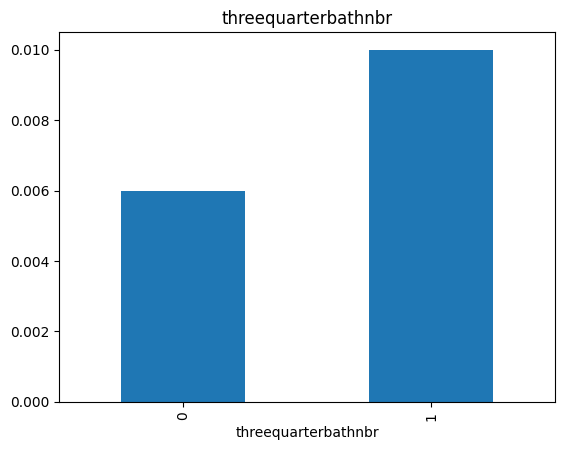

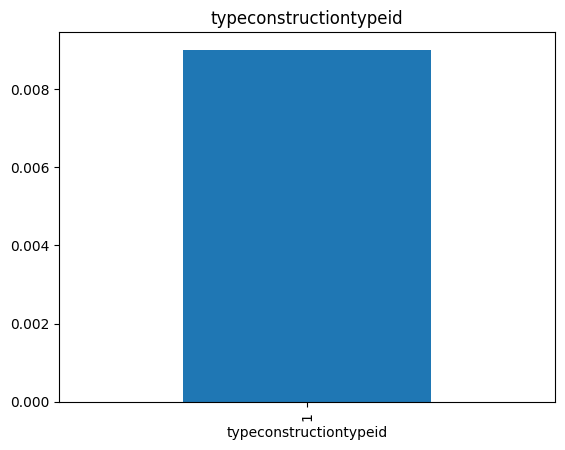

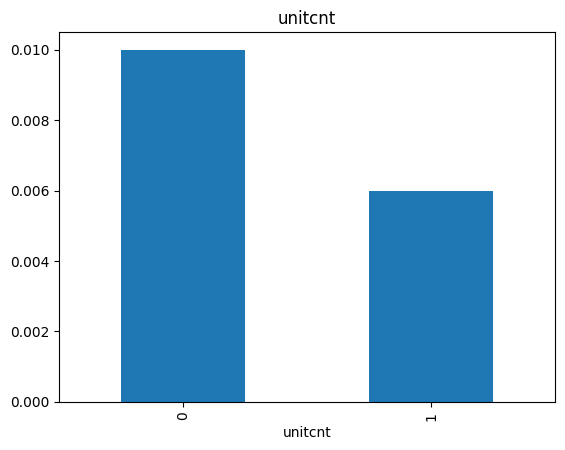

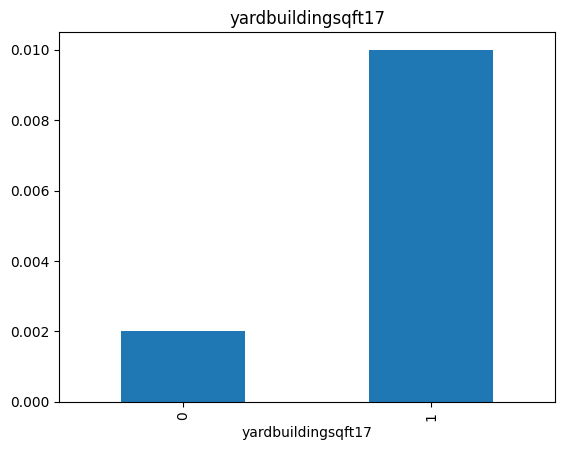

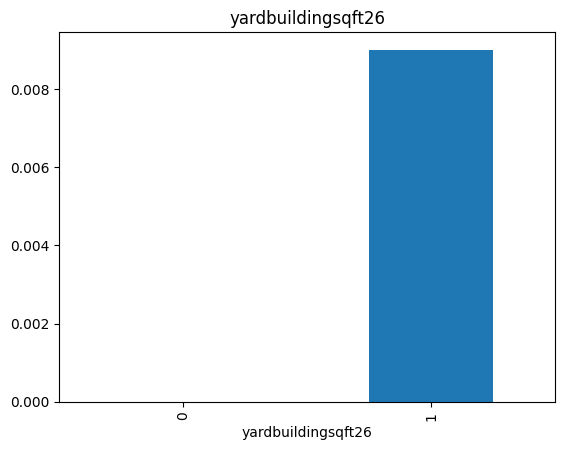

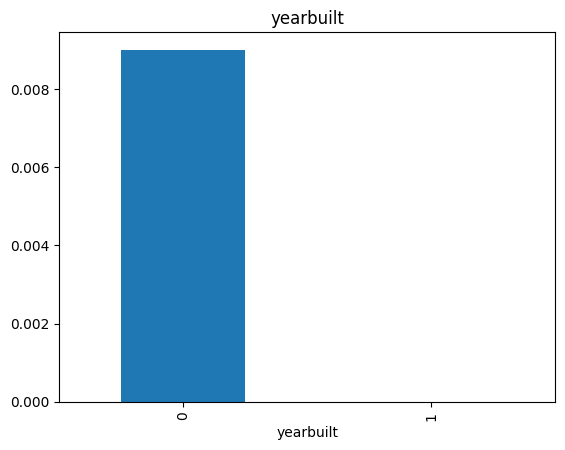

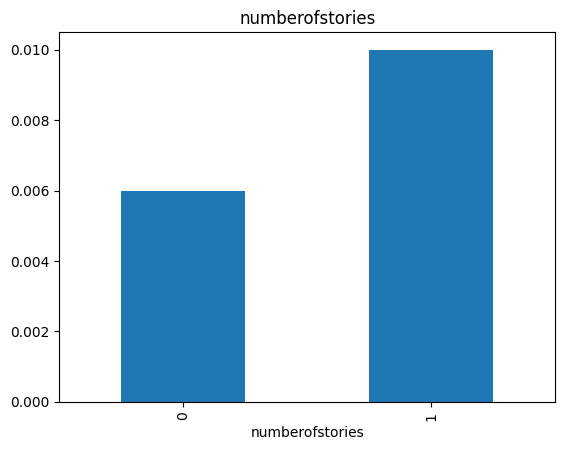

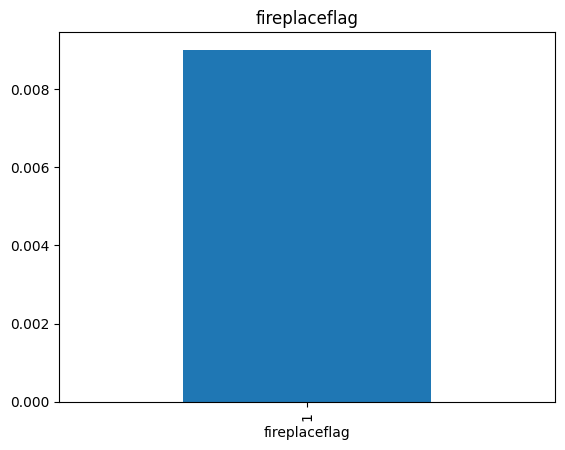

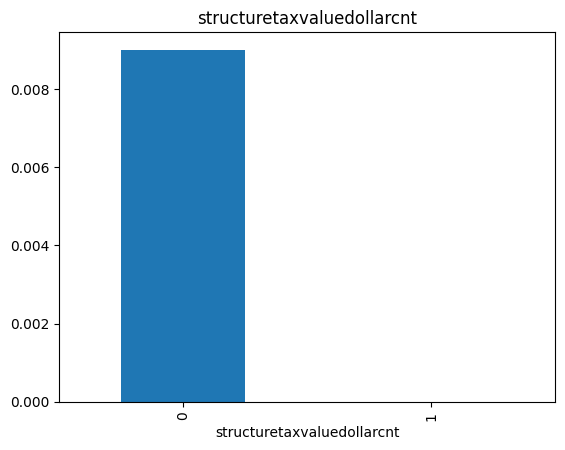

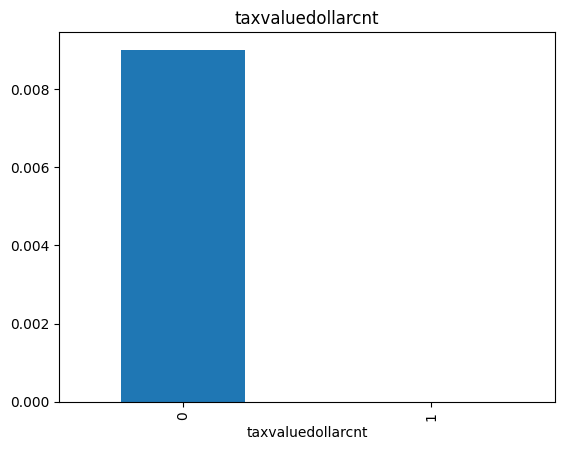

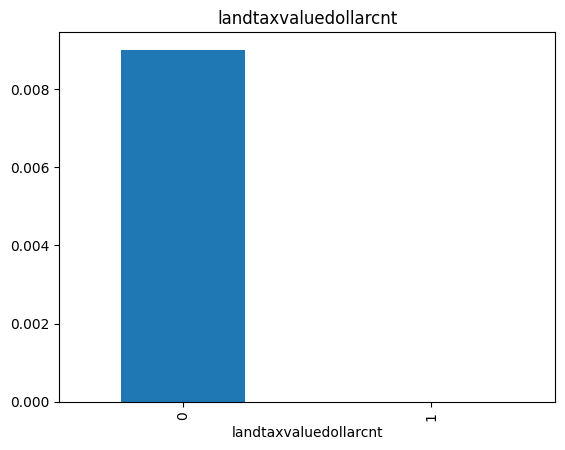

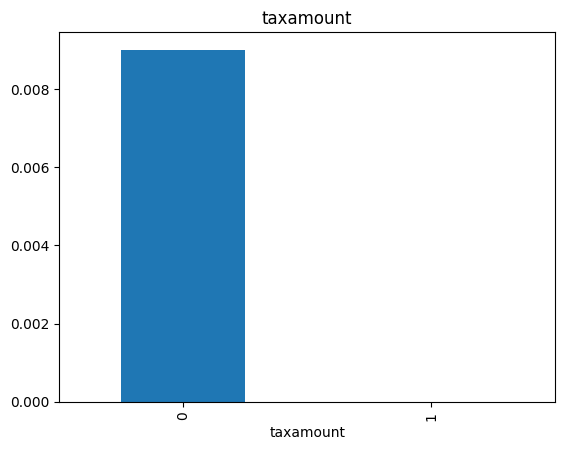

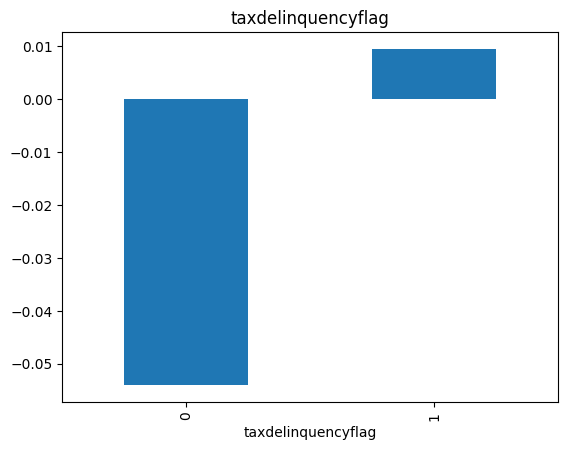

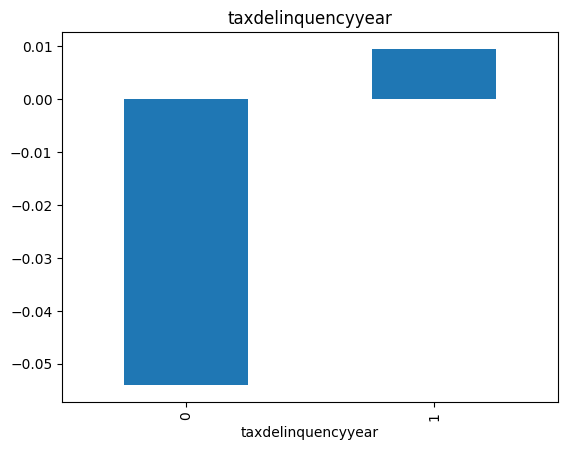

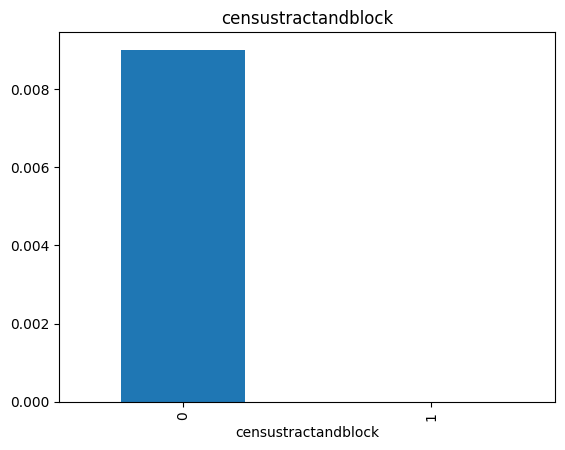

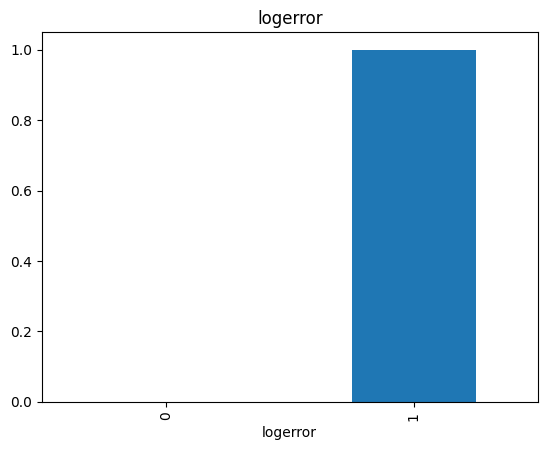

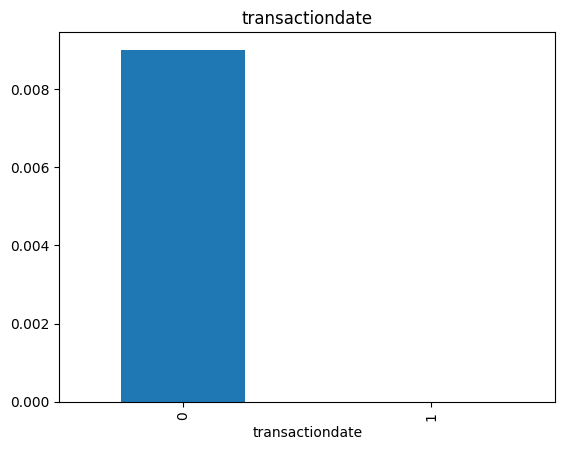

In [12]:
# Let's analyze missing values
def analyze_missing(df,var):
    new=df.copy()
    new[var]=np.where(new[var].isnull(),1,0) #1 = missing, 0 = no missing
    new.groupby(var)['logerror'].median().plot.bar()
    plt.title(var)
    plt.show()

for var in missing:
    analyze_missing(zillow,var)

In [13]:
print('Total number of missing values in each category: ',len(missing))

Total number of missing values in each category:  49


# Data Visualization

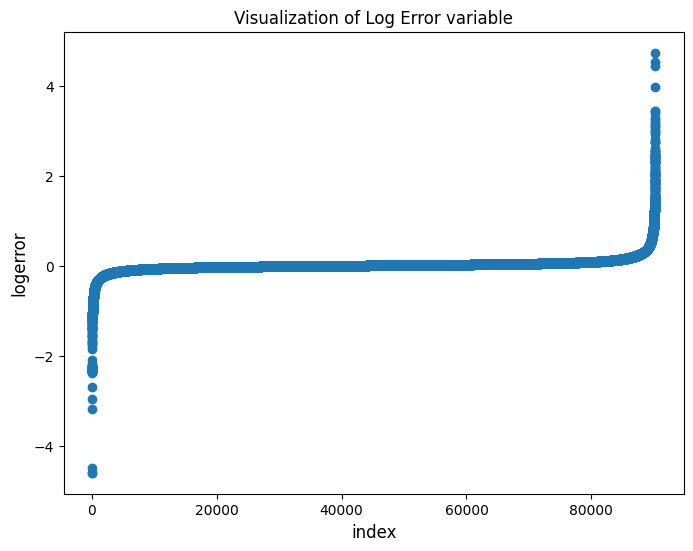

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]),np.sort(train.logerror.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('logerror',fontsize=12)
plt.title('Visualization of Log Error variable')
plt.show()

# Data Cleaning and Feature Engineering

In [33]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [15]:
df = zillow.copy()
df.shape

(9999, 60)

In [18]:
duplicate=df[df.duplicated('parcelid')]
duplicate.shape

(0, 60)

In [19]:
df.isnull().mean()*100

parcelid                          0.000000
airconditioningtypeid            71.977198
architecturalstyletypeid        100.000000
basementsqft                     99.919992
bathroomcnt                       0.000000
bedroomcnt                        0.000000
buildingclasstypeid              99.389939
buildingqualitytypeid            13.141314
calculatedbathnbr                 3.830383
decktypeid                       99.259926
finishedfloor1squarefeet         91.309131
calculatedfinishedsquarefeet      0.740074
finishedsquarefeet12             10.481048
finishedsquarefeet13             99.479948
finishedsquarefeet15             90.789079
finishedsquarefeet50             91.309131
finishedsquarefeet6              99.989999
fips                              0.000000
fireplacecnt                     93.489349
fullbathcnt                       3.830383
garagecarcnt                     91.279128
garagetotalsqft                  91.279128
hashottuborspa                   99.129913
heatingorsy

In [24]:
def drop_missing(df):
    mis_var = [var for var in df.columns if df[var].isnull().sum() > 0]
    df[mis_var].isnull().sum()

    limit = np.abs((df.shape[0] * 0.6))
    var_to_be_dropped = [var for var in mis_var if df[var].isnull().sum() > limit]
    
    df.drop(columns=var_to_be_dropped, axis=1, inplace=True)
    return df

df=drop_missing(df)
df.shape

(9999, 30)

In [27]:
def replace_miss(df,mis_vars):
    for var in mis_vars:
        df[var] = df[var].fillna(df[var].mode()[0])
    return df

mis_var = [var for var in df.columns if df[var].isnull().sum() > 0]
df = replace_miss(df, mis_var)
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,10754147,0.0,0.0,7.0,2.0,1440.0,1440.0,6037,2.0,2.0,...,96337.0,0.0,1.0,1950.0,100000.0,9.0,2015,9.0,650.15,6.037139e+13
1,10759547,0.0,0.0,7.0,2.0,1440.0,1440.0,6037,2.0,2.0,...,96337.0,0.0,1.0,1950.0,100000.0,27516.0,2015,27516.0,650.15,6.037139e+13
2,10843547,0.0,0.0,7.0,2.0,73026.0,1440.0,6037,2.0,2.0,...,96095.0,0.0,2.0,1950.0,650756.0,1413387.0,2015,762631.0,20800.37,6.037139e+13
3,10859147,0.0,0.0,7.0,2.0,5068.0,1440.0,6037,2.0,2.0,...,96424.0,0.0,1.0,1948.0,571346.0,1156834.0,2015,585488.0,14557.57,6.037139e+13
4,10879947,0.0,0.0,7.0,2.0,1776.0,1440.0,6037,2.0,2.0,...,96450.0,0.0,1.0,1947.0,193796.0,433491.0,2015,239695.0,5725.17,6.037139e+13


In [34]:
categorical = [var for var in df.columns if df[var].dtypes == 'O']
categorical

def encode_cat(df, categorical):    
    for i in range(len(categorical)):
        var = categorical[i]
        var_le = LabelEncoder()
        var_labels = var_le.fit_transform(df[var])
        var_mappings = {index: label for index, label in enumerate(var_le.classes_)}
        
        df[(var + '_labels')] = var_labels
        df.drop(columns=var, axis=1, inplace=True)
        
    return df

df = encode_cat(df, categorical)
df.head(10)

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertycountylandusecode_labels,propertyzoningdesc_labels
0,10754147,0.0,0.0,7.0,2.0,1440.0,1440.0,6037,2.0,2.0,...,1.0,1950.0,100000.0,9.0,2015,9.0,650.15,6.037139e+13,9,318
1,10759547,0.0,0.0,7.0,2.0,1440.0,1440.0,6037,2.0,2.0,...,1.0,1950.0,100000.0,27516.0,2015,27516.0,650.15,6.037139e+13,7,375
2,10843547,0.0,0.0,7.0,2.0,73026.0,1440.0,6037,2.0,2.0,...,2.0,1950.0,650756.0,1413387.0,2015,762631.0,20800.37,6.037139e+13,44,304
3,10859147,0.0,0.0,7.0,2.0,5068.0,1440.0,6037,2.0,2.0,...,1.0,1948.0,571346.0,1156834.0,2015,585488.0,14557.57,6.037139e+13,44,304
4,10879947,0.0,0.0,7.0,2.0,1776.0,1440.0,6037,2.0,2.0,...,1.0,1947.0,193796.0,433491.0,2015,239695.0,5725.17,6.037139e+13,47,313
5,10898347,0.0,0.0,7.0,2.0,2400.0,1440.0,6037,2.0,2.0,...,1.0,1943.0,176383.0,283315.0,2015,106932.0,3661.28,6.037139e+13,47,306
6,10933547,0.0,0.0,7.0,2.0,1440.0,1440.0,6037,2.0,2.0,...,1.0,1950.0,397945.0,554573.0,2015,156628.0,6773.34,6.037139e+13,15,304
7,10940747,0.0,0.0,7.0,2.0,3611.0,1440.0,6037,2.0,2.0,...,1.0,1946.0,101998.0,688486.0,2015,586488.0,7857.84,6.037139e+13,47,89
8,10954547,0.0,0.0,7.0,2.0,1440.0,1440.0,6037,2.0,2.0,...,1.0,1950.0,100000.0,9.0,2015,9.0,650.15,6.037139e+13,9,92
9,10976347,0.0,0.0,7.0,2.0,3754.0,1440.0,6037,2.0,2.0,...,1.0,1978.0,218440.0,261201.0,2015,42761.0,4054.76,6.037139e+13,47,868


In [35]:
z = np.abs(stats.zscore(df))
outliers=df[(z<3).all(axis=1)]
outliers.shape

(7680, 30)

In [36]:
outliers.to_csv('final_zillow.csv',index=False)

# Machine Learning

## Building Model

In [37]:
import xgboost
from sklearn.model_selection import train_test_split

from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Model Testing and Metrics

### Mean Absolute Error (MAE) Score

# Model Output